<a href="https://colab.research.google.com/github/Talendar/stocks_prices_prediction/blob/main/stocks_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prediction of Stocks Prices with Deep Learning**

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output, display
from google.colab import files

import tensorflow as tf
tf.keras.backend.set_floatx('float64')
from tensorflow.keras.callbacks import Callback

!pip install investpy
import investpy

In [8]:
NUM_SESSIONS = 10  # number of previous trading sessions the model will analyse in order to make a prediction
NORMALIZE_LABELS = False

TRAIN_PC, VAL_PC, TEST_PC = 0.85, 0.1, 0.05
assert (TRAIN_PC + VAL_PC + TEST_PC) == 1

LABELS_NAMES = [    # values that the model will try to predict
    "close",
]

In [2]:
mape = tf.keras.metrics.MeanAbsolutePercentageError()
mae = tf.keras.metrics.MeanAbsoluteError()
mse = tf.keras.metrics.MeanSquaredError()


class ClearCallback(Callback):
    """ Handles the cleaning of the log during the training of a model. """

    def on_epoch_end(self, epoch, logs=None):
        """ Clears the log. Called when a training epoch ends. """
        clear_output(wait=True)


def eval(model, dataset, denorm_labels, title, plot_samples=30):
    predictions = model.predict(dataset)
    if NORMALIZE_LABELS:
        predictions = denormalize(predictions,
                                  dmin=norm_l_min.values, 
                                  dmax=norm_l_max.values)
        
    denorm_labels = denorm_labels[:len(predictions)]
    results = {"mae": mae(denorm_labels, predictions),
               "mape": mape(denorm_labels, predictions),
               "mse": mse(denorm_labels, predictions)}

    print("  . Mean Abs. Error: %.2f" % results["mae"])
    print("  . Mean Abs. Percentage Error: %.4f%%" % results["mape"])
    print("  . Mean Squared Error: %.f\n\n" % results["mse"])

    i = np.random.randint(len(predictions) - plot_samples)
    predictions = predictions[i : (i + plot_samples)]
    denorm_labels = denorm_labels[i : (i + plot_samples)]

    bars_errors = [[], []]
    for p, l in zip(predictions, denorm_labels.values):
        d = l - p
        if d > 0:
            bars_errors[1].append(d)
            bars_errors[0].append(0)
        else:
            bars_errors[0].append(-d)
            bars_errors[1].append(0)

    plt.rc('xtick',labelsize=14, color="#DCDCDC")
    plt.rc('ytick',labelsize=14, color="#DCDCDC")
    plt.rcParams.update({'legend.fontsize': 18, 'legend.handlelength': 2})

    fig = plt.figure(figsize=(20, 9))
    ax = fig.add_subplot()
    ax.plot(denorm_labels.index, denorm_labels, marker='o', c='#2ca02c', label='Labels', linewidth=3)
    ax.errorbar(denorm_labels.index, predictions, yerr=bars_errors, linestyle="--", 
                 marker='s', label='Predictions', c='#ff7f0e', alpha=0.6, linewidth=3,
                 ecolor="#ff0000", elinewidth=2)[-1][0].set_linestyle(':')

    ax.legend();
    ax.set_title(title, fontsize=22, color="#E0E0E0")
    ax.set_ylabel('Ibovespa\n', fontsize=19, color="#E0E0E0")
    ax.set_xlabel('\nDate', fontsize=19, color="#E0E0E0")

    return results

## **1) Preparing the data**

#### **1.1) Retrieving**

   [TIME INTERVAL] from 2000-12-27 00:00:00 to 2000-12-28 00:00:00
[TRADING SESSIONS] 4966

>>> DATA:


,open,high,low,close,volume
Date,,,,,
2020-11-27,110228.62,111603.41,110161.10,110575.47,8790310
2020-11-30,110598.01,110933.68,108829.15,108893.32,19299996
2020-12-01,108897.29,111839.86,108897.29,111399.91,11324807
2020-12-02,111401.76,112315.42,110579.16,111878.53,9814327
2020-12-03,111873.88,113377.33,111873.88,112291.59,11474202




>>> STATS:


,open,high,low,close,volume
count,4966.000000,4966.000000,4966.000000,4966.000000,4.966000e+03
mean,51474.238218,52015.419585,50939.691353,51492.775244,7.399362e+07
std,25199.508558,25412.452147,24986.669871,25209.610686,1.226874e+08
min,8397.120000,8513.300000,8224.610000,8370.880000,0.000000e+00
25%,33201.177500,33479.570000,32841.307500,33240.520000,2.786271e+06
50%,53631.700000,54133.245000,53009.785000,53632.810000,4.384294e+06
75%,65294.932500,65945.835000,64684.915000,65314.052500,1.211384e+08
max,119527.630000,119593.100000,118108.300000,119527.630000,9.949626e+08


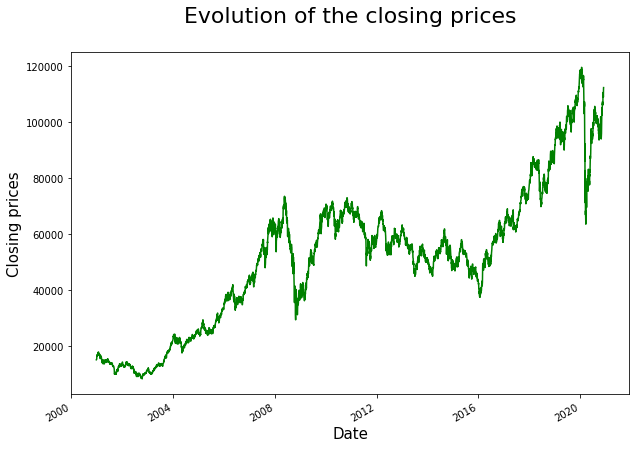

In [5]:
data = investpy.get_index_historical_data(index='Bovespa',
                                          country='Brazil',
                                          from_date='01/01/2000',
                                          to_date='03/12/2020')

data.drop("Currency", axis=1, inplace=True)
data.columns = data.columns.str.lower()

print("   [TIME INTERVAL] from %s to %s" % (data.index[0], data.index[1]))
print("[TRADING SESSIONS] %d\n" % len(data))

print(">>> DATA:")
display(data.tail())

print("\n\n>>> STATS:")
display(data.describe())

print("\n\n")
ax = data["close"].plot(figsize=(10,7), color="green")
ax.set_title("Evolution of the closing prices\n", fontsize=22);
ax.set_ylabel("Closing prices", fontsize="15");
ax.set_xlabel("Date", fontsize="15");

#### **1.2) Splitting data**

In [6]:
def features_and_labels(data):
    return data[:-NUM_SESSIONS], data[LABELS_NAMES][NUM_SESSIONS:]


def assert_labels(data, labels):
    data, labels = data[LABELS_NAMES].values, labels.values
    for i in range(len(labels) - NUM_SESSIONS):
        assert np.array_equal(labels[i], data[i + NUM_SESSIONS])


n = len(data)
train_data, train_labels = features_and_labels(data[:int(n*TRAIN_PC)])
val_data, val_labels = features_and_labels(data[int(n*TRAIN_PC) : int(n * (TRAIN_PC + VAL_PC))])
test_data, test_labels = features_and_labels(data[int(n * (TRAIN_PC + VAL_PC)):])

print("Asserting labels... ", end="")
assert_labels(train_data, train_labels)
assert_labels(val_data, val_labels)
assert_labels(test_data, test_labels)
print("done!\n")

print("  [TRAINING RANGE] {} to {}".format(str(train_data.index[0])[:10], str(train_data.index[-1])[:10]))
print("[VALIDATION RANGE] {} to {}".format(str(val_data.index[0])[:10], str(val_data.index[-1])[:10]))
print("      [TEST RANGE] {} to {}\n".format(str(test_data.index[0])[:10], str(test_data.index[-1])[:10]))

print(f"  [TRAINING DATA SHAPE] Features: {train_data.shape}  |  Labels: {train_labels.shape}")
print(f"[VALIDATION DATA SHAPE] Features: {val_data.shape}  |  Labels: {val_labels.shape}")
print(f"      [TEST DATA SHAPE] Features: {test_data.shape}  |  Labels: {test_labels.shape}")

Asserting labels... done!

  [TRAINING RANGE] 2000-12-27 to 2017-11-13
[VALIDATION RANGE] 2017-11-30 to 2019-11-18
      [TEST RANGE] 2019-12-04 to 2020-11-19

  [TRAINING DATA SHAPE] Features: (4211, 5)  |  Labels: (4211, 1)
[VALIDATION DATA SHAPE] Features: (486, 5)  |  Labels: (486, 1)
      [TEST DATA SHAPE] Features: (239, 5)  |  Labels: (239, 1)


#### **1.3) Data normalization**

In [7]:
def min_max_norm(data, dmin=None, dmax=None):
    if dmin is None:
        dmin = data.min(axis=0)

    if dmax is None:
        dmax = data.max(axis=0)

    return (data - dmin) / (dmax - dmin), dmin, dmax


def denormalize(data, dmin, dmax):
    return (data * (dmax - dmin)) + dmin


norm_train_data, norm_f_min, norm_f_max = min_max_norm(train_data)
norm_val_data = min_max_norm(val_data, norm_f_min, norm_f_max)[0]
norm_test_data = min_max_norm(test_data, norm_f_min, norm_f_max)[0]

norm_train_labels = norm_val_labels = norm_test_labels = None
if NORMALIZE_LABELS:
    norm_train_labels, norm_l_min, norm_l_max = min_max_norm(train_labels)
    norm_val_labels = min_max_norm(val_labels, norm_l_min, norm_l_max)[0]
    norm_test_labels = min_max_norm(test_labels, norm_l_min, norm_l_max)[0]

print(">>> NORMALIZED TRAINING DATA:")
display(norm_train_data.tail())

print("\n\n>>> NORMALIZED VALIDATION DATA:")
display(norm_val_data.tail())

print("\n\n>>> NORMALIZED TEST DATA:")
display(norm_test_data.tail())

>>> NORMALIZED TRAINING DATA:


,open,high,low,close,volume
Date,,,,,
2017-11-07,0.960945,0.946509,0.937557,0.933329,0.005066
2017-11-08,0.934143,0.949021,0.938748,0.961721,0.003532
2017-11-09,0.961778,0.947331,0.943537,0.940846,0.003423
2017-11-10,0.940920,0.927990,0.930741,0.929696,0.003254
2017-11-13,0.929753,0.923916,0.928638,0.934207,0.002884




>>> NORMALIZED VALIDATION DATA:


,open,high,low,close,volume
Date,,,,,
2019-11-11,1.446687,1.436527,1.440626,1.457274,0.003949
2019-11-12,1.457565,1.436532,1.432135,1.433719,0.005246
2019-11-13,1.433994,1.413773,1.417937,1.423646,0.005366
2019-11-14,1.423806,1.413368,1.426114,1.430888,0.005391
2019-11-18,1.431295,1.424324,1.432334,1.426697,0.004945




>>> NORMALIZED TEST DATA:


,open,high,low,close,volume
Date,,,,,
2020-11-13,1.372141,1.384137,1.377723,1.404163,0.009822
2020-11-16,1.404504,1.409923,1.410159,1.429038,0.011784
2020-11-17,1.429313,1.428512,1.426497,1.440969,0.010363
2020-11-18,1.441203,1.423577,1.429372,1.424508,0.010390
2020-11-19,1.424752,1.416465,1.422095,1.432535,0.008599


#### **1.4) Creating a windowed data generator**

In [9]:
def make_dataset(data, labels, shuffle=True):
    return tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data, targets=labels,
        sequence_length=20,
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=32,
    )


ds_train = make_dataset(norm_train_data, 
                        norm_train_labels if NORMALIZE_LABELS else train_labels)
ds_val = make_dataset(norm_val_data, 
                      norm_val_labels if NORMALIZE_LABELS else val_labels,
                      shuffle=False)
ds_test = make_dataset(norm_test_data, 
                       norm_test_labels if NORMALIZE_LABELS else test_labels,
                       shuffle=False)

sample_x, sample_y = next(iter(ds_train))
print(f"Sample input shape: {sample_x.shape}")
print(f"Sample label shape: {sample_y.shape}")

Sample input shape: (32, 20, 5)
Sample label shape: (32, 1)


## **2) Training a model**

131/131 [==============================] - 4s 27ms/step - loss: 0.0167 - val_loss: 0.0193





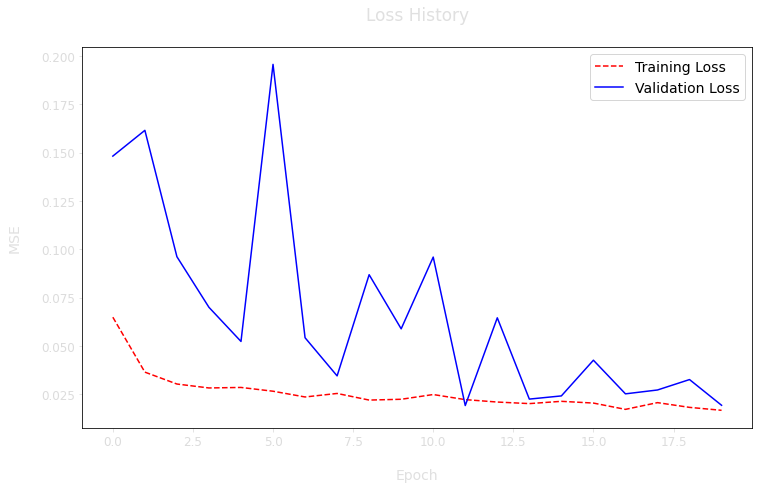

In [165]:
# building and compiling
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1, activation="linear"),
])

model.compile(loss=tf.losses.MeanAbsoluteError(),  #tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),)
              #metrics=[tf.metrics.MeanAbsoluteError()])

# training
epochs = 20
history = model.fit(ds_train, validation_data=ds_val,
                    epochs=epochs,
                    callbacks=[ClearCallback()])

# visualizing loss history
print("\n\n")
plt.rc('xtick',labelsize=12, color="#DCDCDC")
plt.rc('ytick',labelsize=12, color="#DCDCDC")
plt.rcParams.update({'legend.fontsize': 14, 'legend.handlelength': 2})

plt.figure(figsize=(12, 7))
plt.plot(range(epochs), history.history["loss"], 'r--')
plt.plot(range(epochs), history.history["val_loss"], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])

plt.title("Loss History\n", fontsize=17, color="#E0E0E0")
plt.ylabel('MSE\n', fontsize=14, color="#E0E0E0")
plt.xlabel('\nEpoch', fontsize=14, color="#E0E0E0")
plt.show();

> TRAINING DATA:
  . Mean Abs. Error: 1014.30
  . Mean Abs. Percentage Error: 2.8381%
  . Mean Squared Error: 1541674




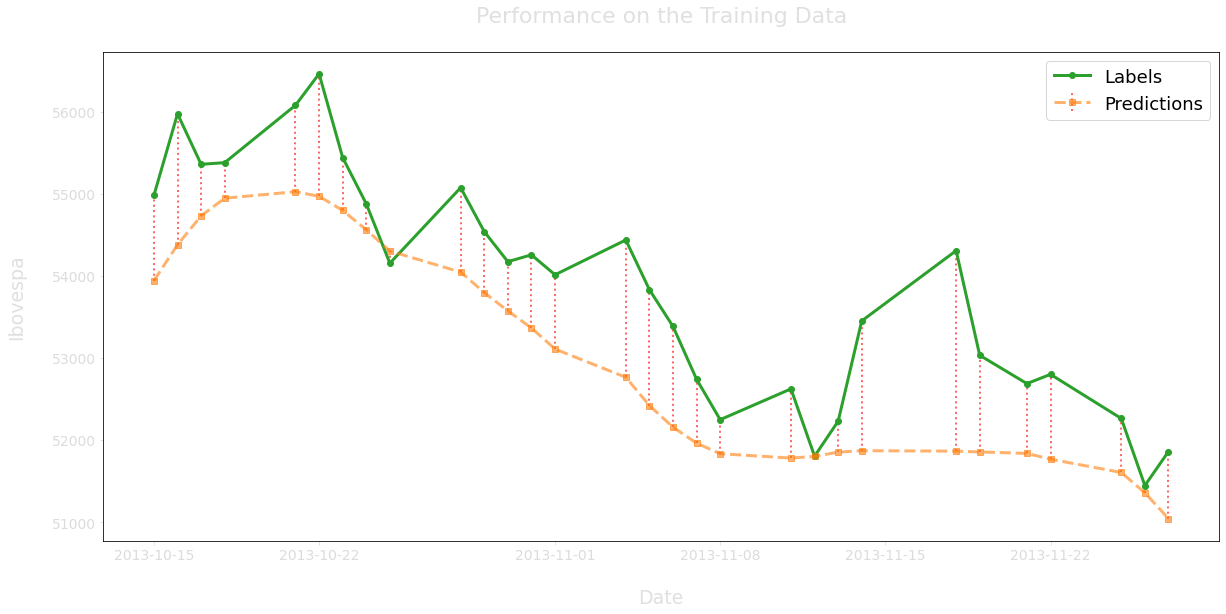

In [166]:
print("> TRAINING DATA:")
train_eval = eval(model, 
                  make_dataset(norm_train_data, 
                               norm_train_labels if NORMALIZE_LABELS else train_labels, 
                               shuffle=False), 
                  train_labels, "Performance on the Training Data\n")

> VALIDATION DATA:
  . Mean Abs. Error: 688.03
  . Mean Abs. Percentage Error: 1.5523%
  . Mean Squared Error: 932317




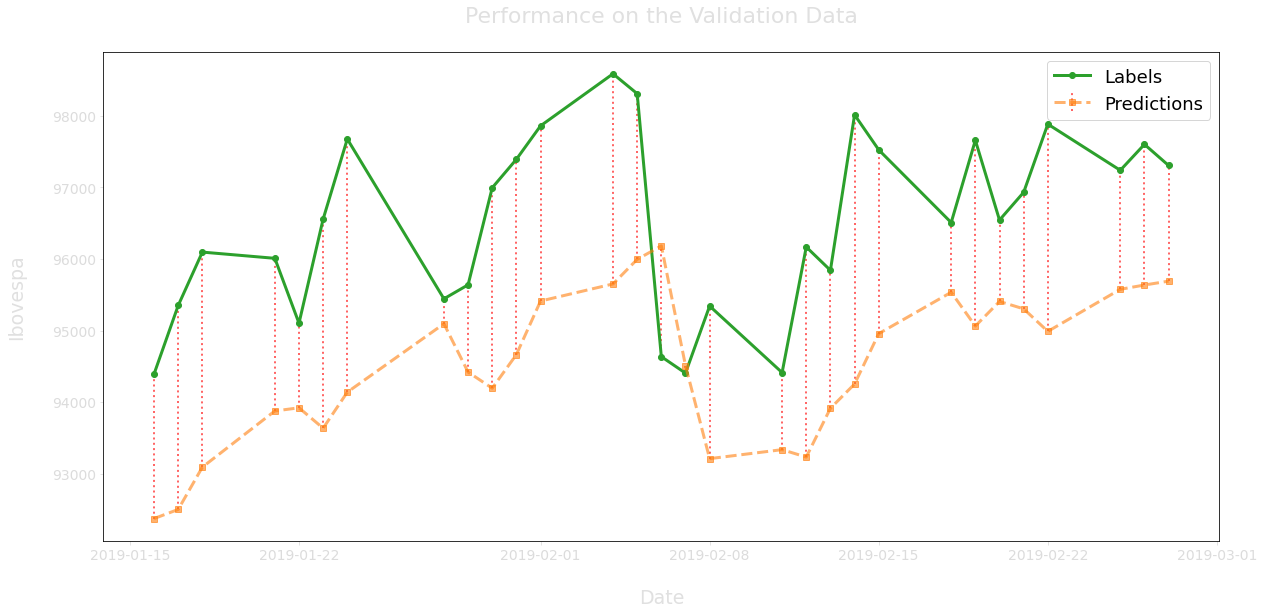

In [134]:
print("> VALIDATION DATA:")
val_eval = eval(model, ds_val, val_labels, "Performance on the Validation Data\n")